In [ ]:
# Imports
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from PIL import Image

import time
import json
import os

import matplotlib.pyplot as plt
import numpy as np


In [4]:
#Directories
data_dir = 'flowers'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

#ImageNet normalization values.
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# Load datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test' : datasets.ImageFolder(test_dir,  transform=data_transforms['test'])
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=64),
    'test' : DataLoader(image_datasets['test'],  batch_size=64)
}


In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [ ]:

model = models.mobilenet_v2(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


input_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(input_features, 102),  # 102 clases de flores
    nn.LogSoftmax(dim=1)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

c:\Users\Elizabeth\Desktop\flowers_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Elizabeth/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100.0%


In [ ]:
epochs = 3 
steps = 0
running_loss = 0
print_every = 30  


for epoch in range(epochs):
    start = time.time()
    model.train()  
    
    for inputs, labels in dataloaders['train']:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()  
            val_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                for val_inputs, val_labels in dataloaders['valid']:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    
                    logps = model.forward(val_inputs)
                    batch_loss = criterion(logps, val_labels)
                    val_loss += batch_loss.item()
                    
                    # Calcular precisión
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == val_labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {val_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")
            
            running_loss = 0
            model.train()  
    
    print(f"Time for epoch {epoch+1}: {time.time() - start:.2f} seconds")


Epoch 1/3.. Train loss: 3.730.. Validation loss: 1.816.. Validation accuracy: 0.652
Epoch 1/3.. Train loss: 1.668.. Validation loss: 0.900.. Validation accuracy: 0.793
Epoch 1/3.. Train loss: 1.249.. Validation loss: 0.617.. Validation accuracy: 0.865
Time for epoch 1: 588.30 seconds
Epoch 2/3.. Train loss: 0.968.. Validation loss: 0.497.. Validation accuracy: 0.887
Epoch 2/3.. Train loss: 0.759.. Validation loss: 0.421.. Validation accuracy: 0.900
Epoch 2/3.. Train loss: 0.750.. Validation loss: 0.424.. Validation accuracy: 0.892
Time for epoch 2: 551.42 seconds
Epoch 3/3.. Train loss: 0.739.. Validation loss: 0.448.. Validation accuracy: 0.883
Epoch 3/3.. Train loss: 0.704.. Validation loss: 0.352.. Validation accuracy: 0.903
Epoch 3/3.. Train loss: 0.646.. Validation loss: 0.381.. Validation accuracy: 0.894
Epoch 3/3.. Train loss: 0.633.. Validation loss: 0.340.. Validation accuracy: 0.906
Time for epoch 3: 618.82 seconds


In [ ]:
# Evslustion
model.eval()

# Turn off gradients for validation to save memory and computation
with torch.no_grad():
    test_loss = 0
    accuracy = 0

    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"\nTest Loss: {test_loss/len(dataloaders['test']):.3f}.. "
      f"Test Accuracy: {accuracy/len(dataloaders['test']):.3f}")



Test Loss: 0.376.. Test Accuracy: 0.907


In [15]:
# Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'arch': 'mobilenet_v2',
    'class_to_idx': model.class_to_idx,
    'state_dict': model.state_dict(),
    'classifier': model.classifier,
}

torch.save(checkpoint, 'checkpoint.pth')


In [18]:
# Load a model from checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu', weights_only=False)
    
    # Load the pre-trained architecture
    if checkpoint['arch'] == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
    else:
        raise ValueError("Only mobilenet_v2 is supported here.")
    
    # Freeze feature parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Load the classifier
    model.classifier = checkpoint['classifier']
    
    # Load trained weights
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model


In [19]:
# Reload the model
loaded_model = load_checkpoint('checkpoint.pth')
print(loaded_model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a NumPy array
    '''
    image = Image.open(image_path).convert("RGB")
    
    # Resize so the shortest side is 256 pixels
    if image.size[0] < image.size[1]:
        image.thumbnail((256, image.size[1]))
    else:
        image.thumbnail((image.size[0], 256))

    # Crop the center 224x224
    left = (image.width - 224) / 2
    top = (image.height - 224) / 2
    right = left + 224
    bottom = top + 224
    image = image.crop((left, top, right, bottom))
    
    # Convert to numpy and scale
    np_image = np.array(image) / 255.0

    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions to match PyTorch format (C, H, W)
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


In [21]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()  # Evaluation mode
    image = process_image(image_path)
    
    # Convert to tensor
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    
    # Move to same device as model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
    
    probs, indices = torch.topk(torch.exp(output), topk)
    probs = probs.cpu().numpy().squeeze()
    indices = indices.cpu().numpy().squeeze()

    # Convert indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return probs, classes


In [22]:
def view_classify(image_path, probs, classes, cat_to_name):
    ''' Display image and bar chart of class predictions '''
    image = process_image(image_path)
    image = image.transpose((1, 2, 0))  # Convert to HWC for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Get flower names
    flower_names = [cat_to_name[str(cls)] for cls in classes]

    # Plot
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), nrows=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(flower_names[0])

    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Put top prediction on top
    ax2.set_xlabel('Probability')

    plt.tight_layout()
    plt.show()


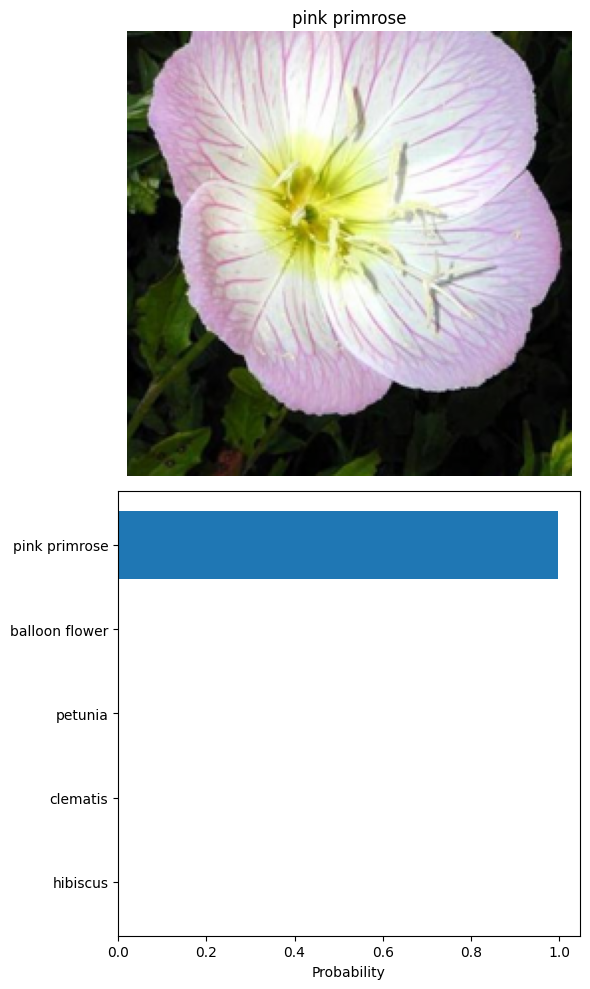

In [23]:
image_path = 'flowers/test/1/image_06743.jpg' 
probs, classes = predict(image_path, loaded_model)
view_classify(image_path, probs, classes, cat_to_name)
